In [1]:
import logging
import os
import sys
import tempfile
import warnings

import cmdstanpy
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
from plotly.subplots import make_subplots
from scipy.stats import gaussian_kde
from tqdm import tqdm

sys.path.append("../src/features")
from plots import _add_ci_traces, _calculate_ci  # noqa: E402

np.random.seed(0)

/opt/homebrew/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
pio.renderers.default = "notebook"
warnings.filterwarnings("ignore")
logging.getLogger("tqdm").setLevel(logging.ERROR)

In [3]:
def run_model(stan_code, data, means, iter_sampling):
    ranks = []
    posterior_means = []
    with tempfile.NamedTemporaryFile(mode="w", suffix=".stan", delete=False) as f:
        f.write(stan_code)
        stan_file_path = f.name
    try:
        n, s = data.shape
        model = cmdstanpy.CmdStanModel(stan_file=stan_file_path)
        logging.getLogger("cmdstanpy").setLevel(logging.ERROR)
        for i in tqdm(range(s)):
            stan_data = {"N": n, "y": data[:, i].tolist()}

            fit = model.sample(
                data=stan_data,
                chains=1,
                iter_warmup=100,
                iter_sampling=iter_sampling,
                show_progress=False,
            )

            samples = fit.stan_variables()
            ranks.append(int(np.sum(samples["mu"] < means[i])))
            posterior_means.append(np.mean(samples["mu"]))
    finally:
        os.unlink(stan_file_path)

    return ranks, posterior_means

In [4]:
def generate_unique_ranks(n_possible_ranks, ranks):
    unique_ranks, counts = np.unique(ranks, return_counts=True)
    all_ranks = np.arange(n_possible_ranks + 1)
    all_counts = np.zeros(n_possible_ranks + 1, dtype=int)
    all_counts[unique_ranks] = counts

    return all_ranks, all_counts

In [5]:
def plot_ecdf_diff(ranks, n_possible_ranks):
    unique_ranks, counts = generate_unique_ranks(n_possible_ranks, ranks)
    unique_ranks = unique_ranks[1:-1] / n_possible_ranks
    counts = counts[1:-1]
    counts = counts / np.sum(counts)

    fig = px.scatter(
        x=unique_ranks,
        y=(
            np.cumsum(counts)
            - np.linspace(
                0 + 1 / (n_possible_ranks + 1), 1, n_possible_ranks - 1, endpoint=True
            )
        ),
        title="Empirical Distribution of Ranks",
    )

    alpha = 0.95
    z_plot, intervals = _calculate_ci(len(ranks), n_possible_ranks, alpha)
    _add_ci_traces(fig, z_plot, intervals, alpha, is_diff=True)

    fig.update_layout(
        xaxis={"range": [0, 1], "title": "Rank"},
        yaxis={"title": "Cumulative Probability"},
        plot_bgcolor="white",
        paper_bgcolor="white",
        showlegend=False,
    )

    return fig

In [6]:
def plot_normals(prior_params, posterior_means):
    """
    Create a plotly graph with two normal distributions.

    Parameters:
    prior_params: tuple (mean, std) for first normal distribution
    posterior_means: array of posterior means

    Returns:
    plotly.graph_objects.Figure: Plotly figure with both normal distributions
    """
    mean, std = prior_params

    x_min = min(-4, mean - 4 * std)
    x_max = max(4, mean + 4 * std)
    x = np.linspace(x_min, x_max, 1000)

    y1 = (1 / (np.sqrt(2 * np.pi))) * np.exp(-0.5 * x**2)
    y2 = (1 / (std * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x - mean) / std) ** 2)

    fig = go.Figure()
    fig.add_trace(
        go.Scatter(x=x, y=y1, mode="lines", line={"color": "blue", "width": 2})
    )

    fig.add_trace(
        go.Scatter(x=x, y=y2, mode="lines", line={"color": "red", "width": 2})
    )

    kde = gaussian_kde(posterior_means)
    y_kde = kde(x)

    fig.add_trace(
        go.Scatter(x=x, y=y_kde, mode="lines", line={"color": "black", "width": 2})
    )

    fig.update_layout(
        title="Comparison of Two Normal Distributions",
        xaxis_title="Value",
        yaxis_title="Probability Density",
        hovermode="x unified",
        width=800,
        height=500,
        showlegend=False,
        plot_bgcolor="white",
        paper_bgcolor="white",
    )

    return fig

In [7]:
STAN_CODE = """
data {{
  int<lower=1> N;
  vector[N] y;
}}

parameters {{
  real mu;
}}

model {{
  mu ~ normal({mu_prior}, 1);
  y ~ normal(mu, {sigma_prior});
}}
"""


def generate_model_code(mu_prior, sigma_prior):
    return STAN_CODE.format(mu_prior=mu_prior, sigma_prior=sigma_prior)

In [8]:
def generate_sbc_plot(figs):
    n_rows = len(figs)
    fig = make_subplots(rows=n_rows, cols=2)

    for i, (title, (normals_fig, ecdf_fig, prior_params)) in enumerate(figs.items()):
        for trace in normals_fig.data:
            fig.add_trace(trace, row=i + 1, col=1)
        for trace in ecdf_fig.data:
            fig.add_trace(trace, row=i + 1, col=2)

        prior = (
            "\\left(\\mathcal{{N}}("
            f"{prior_params[0]}, {prior_params[1] ** 2}"
            ")\\right)"
        )
        fig.add_annotation(
            text=f"$\\Large \\text{{{title} }}{prior}$",
            xref="paper",
            yref="paper",
            x=0.5,
            y=1 - i / n_rows - i * 0.01,
            xanchor="center",
            yanchor="bottom",
            showarrow=False,
        )

        fig.update_xaxes(title_text="Value", row=i + 1, col=1)
        fig.update_yaxes(title_text="Probability Density", row=i + 1, col=1)
        fig.update_xaxes(title_text="Rank", row=i + 1, col=2)
        fig.update_yaxes(title_text="ECDF Difference", row=i + 1, col=2)

    fig.update_layout(
        height=1500,
        width=1000,
        showlegend=False,
        plot_bgcolor="white",
        paper_bgcolor="white",
        margin={"t": 30, "b": 30, "l": 30, "r": 30},
    )

    return fig

In [9]:
def run_scenario(mu_prior, sigma_prior):
    stan_code = generate_model_code(mu_prior, sigma_prior)
    ranks, posterior_means = run_model(stan_code, DATA, MEANS, L)
    normals_fig = plot_normals((mu_prior, sigma_prior), posterior_means)
    ecdf_fig = plot_ecdf_diff(ranks, L)
    return normals_fig, ecdf_fig, (mu_prior, sigma_prior)

In [10]:
N = 10
L = 127
S = 20 * (L + 1)

MEANS = np.random.normal(0, 1, S)
DATA = np.random.normal(MEANS, 1, (N, S))

In [11]:
figs_exact = run_scenario(0, 1)
figs_underestimating = run_scenario(-1, 1)
figs_overestimating = run_scenario(1, 1)
figs_too_narrow = run_scenario(0, 0.5)
figs_too_wide = run_scenario(0, 2)

17:38:14 - cmdstanpy - INFO - compiling stan file /private/var/folders/67/qnnhzk_15ydg7t3gr6_lmx8r0000gq/T/tmpssmr_jf4.stan to exe file /private/var/folders/67/qnnhzk_15ydg7t3gr6_lmx8r0000gq/T/tmpssmr_jf4
17:38:21 - cmdstanpy - INFO - compiled model executable: /private/var/folders/67/qnnhzk_15ydg7t3gr6_lmx8r0000gq/T/tmpssmr_jf4
100%|██████████| 2560/2560 [01:35<00:00, 26.84it/s]


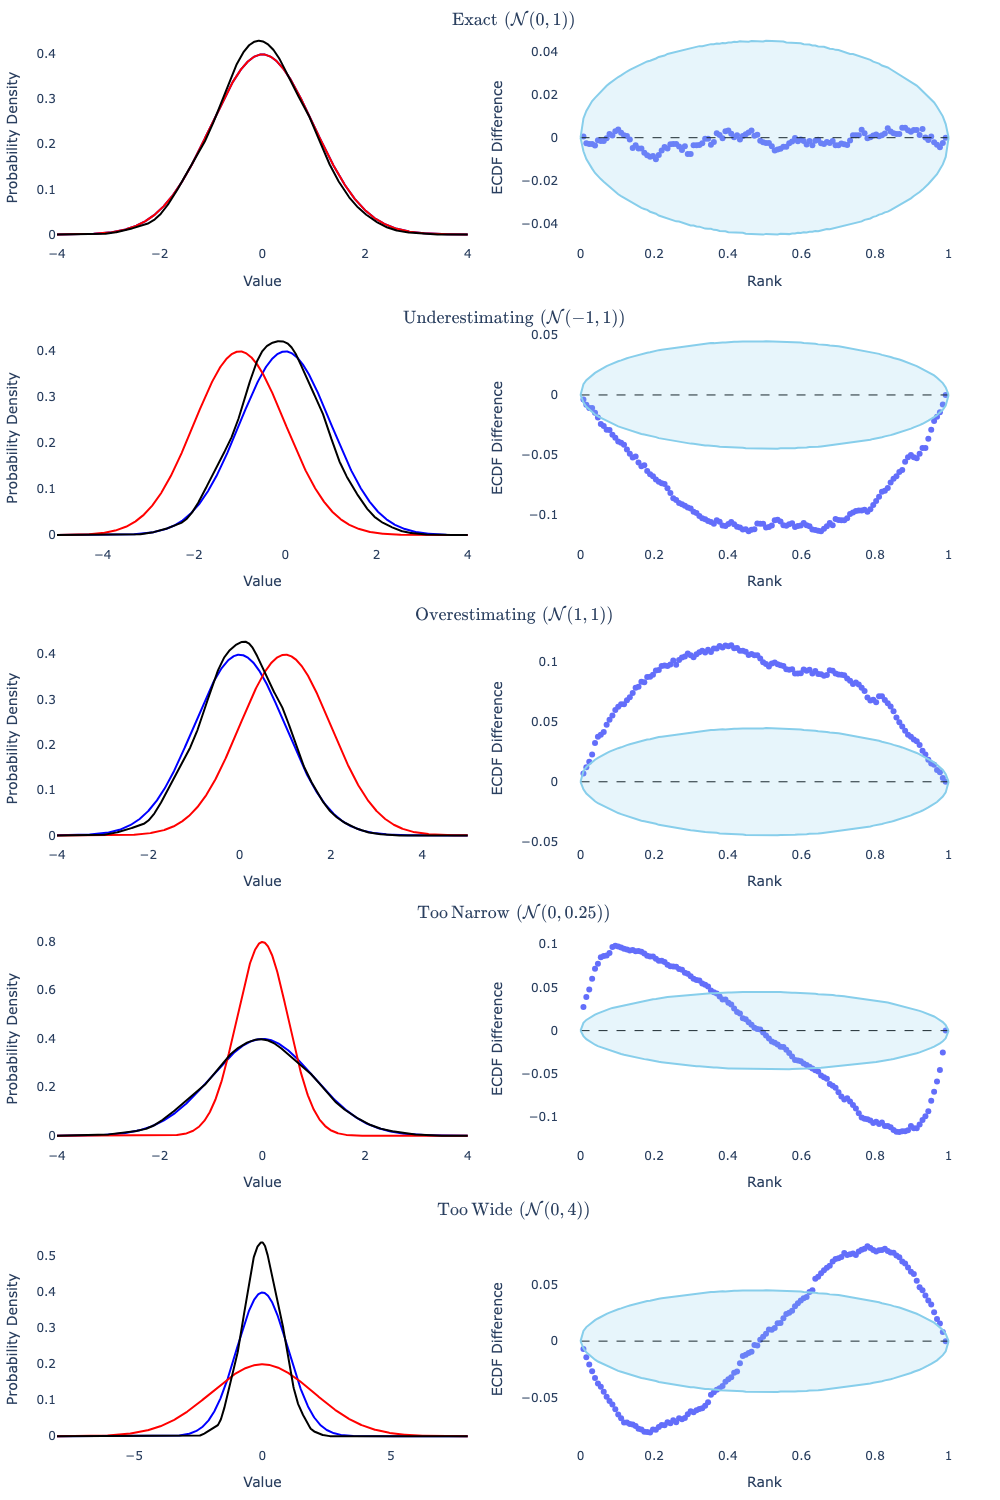

In [12]:
figs = {
    "Exact": figs_exact,
    "Underestimating": figs_underestimating,
    "Overestimating": figs_overestimating,
    "Too Narrow": figs_too_narrow,
    "Too Wide": figs_too_wide,
}

fig = generate_sbc_plot(figs)
fig.write_image("../figures/sbc_visualization.png")
fig.show("png")